In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import newton_krylov
from time import clock as clock
import scipy.sparse.linalg as spla

Testing nonlinear mesh with diffusion equation only and no flux boundary conditions (no source terms). We assume a constant diffusion constant.

Flux:
$$ f = -D \partial_x c(x,t) $$

Conservation law:
$$ \partial_t c(x,t) = - \partial_x f = - \partial_x \left( -D \partial_x c(x,t) \right)$$

Spatial axis $ x \in [0,1] $ - one dimensional. Cell centers vector x

Nondimensionalization

$$ t = \frac{ \tilde{t} }{ T_0 } $$
$$ x = \frac{ \tilde{x} }{ L }  $$
$$ D = \frac{ \tilde{D} }{ D_0 } $$

$$ \frac{1}{T_0} \partial_t c(x,t) = \frac{D_0}{L^2} \left( D \partial_x c(x,t) \right) $$

Reference Time

$$ T_0 = M \cdot \frac{L^2}{D_0} $$

Plugging this into the equation

$$ \frac{D_0}{M L^2} \partial_t c(x,t) = \frac{D_0}{L^2} \left( D \partial_x c(x,t) \right) $$

$$ \partial_t c(x,t) = M \left( D \partial_x c(x,t) \right) $$

Diffusion only with BDF1 time discretization.

$$ f_{i+1,j} = -D_{i} \frac{2 \left( c_{i+1,j} - c_{i,j} \right)}{\Delta x_{i+1} + \Delta x_i} $$

spatial index $i$ and time index $j$

$$ \frac{ c_{i,j} - c_{i,j-1} }{\Delta t} = -\frac{M}{\Delta x_i} \left( -D_{i+1} \frac{2 \left( c_{i+1} - c_i \right)}{\Delta x_{i+1} + \Delta x_i} + D_{i} \frac{2 \left( c_{i} - c_{i-1} \right)}{\Delta x_{i} + \Delta x_{i-1}} \right) $$

$$ c_{i,j} - c_{i,j-1} + \frac{M \cdot\Delta t}{\Delta x_i} \left( -D_{i+1} \frac{2 \left( c_{i+1} - c_i \right)}{\Delta x_{i+1} + \Delta x_i} + D_{i} \frac{2 \left( c_{i} - c_{i-1} \right)}{\Delta x_{i} + \Delta x_{i-1}} \right) = 0 $$

Jacobian calculation, only take the derivative for the actual time index $j$

$$ \partial_{c_{m,j}} \left[ c_{i,j} - c_{i,j-1} + \frac{ M \cdot \Delta t}{\Delta x_i} \left( -D_{i+1} \frac{2 \left( c_{i+1} - c_i \right)}{\Delta x_{i+1} + \Delta x_i} + D_{i} \frac{2 \left( c_{i} - c_{i-1} \right)}{\Delta x_{i} + \Delta x_{i-1}} \right) \right]$$

$$  \delta_{m,i}  + \frac{ M \cdot  \Delta t}{\Delta x_i} \left( - \frac{2 D_{i+1}}{\Delta x_{i+1} + \Delta x_i}\left( \delta_{m,i+1} - \delta_{m,i} \right) +  \frac{2 D_{i}}{\Delta x_{i} + \Delta x_{i-1}}\left( \delta_{m,i} - \delta_{m,i-1} \right) \right) $$

Boundary $i=0$

$$ \partial_{c_{m,j}} \left[ c_{0,j} - c_{0,j-1} + \frac{ M \cdot \Delta t}{\Delta x_0} \left( -D_{1} \frac{2 \left( c_{1} - c_0 \right)}{\Delta x_{1} + \Delta x_0} \right)\right]$$

$$ \delta_{m,0} - \frac{ M \cdot 2D_{1}\Delta t}{\Delta x_0\left( \Delta x_{1} + \Delta x_0 \right)}\left( \delta_{m,1} - \delta_{m,0} \right) $$

Boundary $i=I-1$

$$ \partial_{c_{m,j}} \left[ c_{I-1,j} - c_{I-1,j-1} + \frac{ M \cdot \Delta t}{\Delta x_{I-1}} \left( D_{I-1} \frac{2 \left( c_{I-1} - c_{I-2} \right)}{\Delta x_{I-1} + \Delta x_{I-2}} \right) \right]$$

$$ \delta_{m,I-1} + \frac{ M \cdot 2D_{I-1}\Delta t}{\Delta x_{I-1}\left( \Delta x_{I-1} + \Delta x_{I-2} \right)}\left( \delta_{m,I-1} - \delta_{m,I-2} \right)  $$

Tridiagonal Matrix

$$ A_{i,i-1} = -\frac{M \cdot 2D_i\Delta t}{\Delta x_i \left( \Delta x_i + \Delta x_{i-1} \right)}  $$
$$ A_{i,i} = 1 + \frac{M \cdot 2\Delta t}{\Delta x_i} \left( \frac{D_{i+1}}{\Delta x_{i+1} + \Delta x_{i}} + \frac{D_{i}}{\Delta x_{i} + \Delta x_{i-1}} \right) $$
$$ A_{i,i+1} = -\frac{M \cdot 2D_{i+1}\Delta t}{\Delta x_i\left( \Delta x_{i+1} + \Delta x_i \right)} $$

Boundary $i=0$

$$ A_{0,0} = 1 +  \frac{M \cdot 2D_{1}\Delta t}{\Delta x_0\left( \Delta x_{1} + \Delta x_0 \right)} $$
$$ A_{0,1} = - \frac{M \cdot 2D_1\Delta t}{\Delta x_0 \left( \Delta x_1 + \Delta x_0 \right)} $$

Boundary $i=I-1$:

$$ A_{I-1,I-2} = - \frac{M \cdot 2D_{I-1}\Delta t}{\Delta x_{I-1}\left( \Delta x_{I-1} + \Delta x_{I-2} \right)} $$

$$ A_{I-1,I-1} =1 + \frac{M \cdot 2D_{I-1}\Delta t}{\Delta x_{I-1}\left( \Delta x_{I-1} + \Delta x_{I-2} \right)} $$

In [35]:
def Jacobian( I, Dx, D, Dt, M ):
    
    A = np.zeros([I,I], dtype = np.float64)
    
    # boundary i=0
    A[0,0] = 1 + 2 * D[1] * Dt / ( Dx[0] * (Dx[1] + Dx[0]) )
    A[0,1] = -2 * D[1] * Dt / ( Dx[0] * (Dx[1] + Dx[0]) )
    
    # inner points
    for i in range(1,I-1):
        A[i,i-1] = -2 * Dt * D[i] / ( Dx[i] * (Dx[i] + Dx[i-1]) )
        A[i,i] = 1 + 2 * Dt * ( D[i+1] / (Dx[i+1] + Dx[i]) + D[i] / (Dx[i] + Dx[i-1]) ) / Dx[i]
        A[i,i+1] = -2 * Dt * D[i+1] / ( Dx[i] * (Dx[i+1] + Dx[i]) )
    
    # boundary i=I-1
    A[I-1,I-2] = -2 * Dt * D[I-1] / ( Dx[I-1] * (Dx[I-1] + Dx[I-2]) )
    A[I-1,I-1] = 1 + 2 * Dt * D[I-1] / ( Dx[I-1] * (Dx[I-1] + Dx[I-2]) )
    
    return A

[0.005 0.015 0.025 0.035 0.045 0.055 0.065 0.075 0.085 0.095 0.105 0.115
 0.125 0.135 0.145 0.155 0.165 0.175 0.185 0.195 0.205 0.215 0.225 0.235
 0.245 0.255 0.265 0.275 0.285 0.295 0.305 0.315 0.325 0.335 0.345 0.355
 0.365 0.375 0.385 0.395 0.405 0.415 0.425 0.435 0.445 0.455 0.465 0.475
 0.485 0.495 0.505 0.515 0.525 0.535 0.545 0.555 0.565 0.575 0.585 0.595
 0.605 0.615 0.625 0.635 0.645 0.655 0.665 0.675 0.685 0.695 0.705 0.715
 0.725 0.735 0.745 0.755 0.765 0.775 0.785 0.795 0.805 0.815 0.825 0.835
 0.845 0.855 0.865 0.875 0.885 0.895 0.905 0.915 0.925 0.935 0.945 0.955
 0.965 0.975 0.985 0.995]
[0.         0.00879935 0.01636806 0.02658773 0.04178446 0.0420649
 0.04754416 0.04973128 0.05499384 0.06767372 0.07035092 0.08692842
 0.11288733 0.12071318 0.12916148 0.13330018 0.1367078  0.14807689
 0.14951189 0.15939681 0.16230895 0.17688273 0.18757808 0.20907396
 0.21125041 0.2189018  0.23195249 0.23822124 0.24023244 0.24732329
 0.2486086  0.25989121 0.28336834 0.29054509 0.31719811 

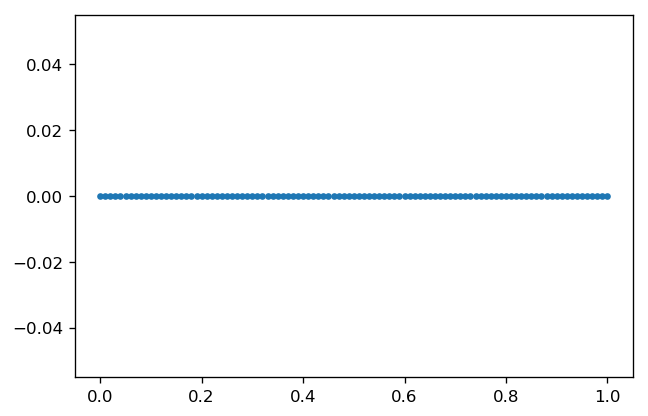

In [4]:
# grid generation
I = 100

xi = np.arange(0.0, 1.0 + 1.0 / (I+1), 1.0 / (I) )

x = np.sin( ( np.pi * xi  ) / 2 ) ** 2
y = np.concatenate(([0.0], np.sort(np.random.rand(I-1)), [1.0]))

x = xi


# extract mitpoint
centers = np.zeros(I, dtype = np.float64)
for i in range(I):
    
    centers[i] = x[i] + (x[i+1] - x[i]) / 2



print(centers)

# nonlinear


print(y)

fig = plt.figure(dpi = 120)

ax = fig.add_subplot(1,1,1)

ax.plot(x, np.zeros(y.shape), ls = "None", marker = ".")

Finite Volume approximation of conservation law:

$$  $$

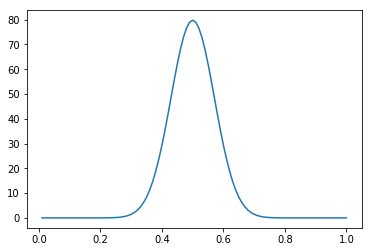

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])

In [5]:
sigma = 0.005
centers = x[:I] + (x[1:] - x[:I])
sol_initial = np.exp( -(centers - 0.5) ** 2 / (2 * sigma)  ) / (sigma * np.sqrt(2*np.pi))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(centers, sol_initial)

plt.show()
centers

In [21]:
M = 1e8
D0 = 1e-12 * 1e9 ** 2 # nm^2/s
L = 10 # nm
T0 = M * L ** 2 / D0

N = 2 ** 15
Dt = 1e-10
time = np.zeros(N, dtype = np.float64 )
for j in range(0, N):
    
    time[j] = j * Dt
    
f_sample = 1.0 / ( N * Dt * T0 )
f_Ny = 1.0 / (2.2 * Dt * T0 )


print("Reference Diffusion [nm^2/s]", D0)
print("Reference Time [s]", T0)
print("Sample frequency [Hz]", f_sample)
print("Nyquist frequency [Hz]", f_Ny)
print("Number of points", N)


Reference Diffusion [nm^2/s] 1000000.0
Reference Time [s] 10000.0
Sample frequency [Hz] 30.517578125
Nyquist frequency [Hz] 454545.45454545453
Number of points 32768


In [17]:
# residual vector
def residual( sol_old, sol_new, Dx, D, I, Dt, M ):
        
    res = np.zeros(I, dtype = np.float64)
    
    # anode boundary condition
    res[0] = (sol_new[0] - sol_old[0] 
            + M * Dt * (-D[1] * ( sol_new[1] - sol_new[0]) / ((Dx[0] + Dx[1]) / 2) ) / Dx[0])
    
    for i in range( 1, I-1 ):

        res[i] = ( sol_new[i] -sol_old[i] 
        + M * Dt * ( -D[i+1] * ( sol_new[i+1] -  sol_new[i]) / ((Dx[i+1] + Dx[i]) / 2.0) 
                       + D[i]  * ( sol_new[i] -  sol_new[i-1]) / ((Dx[i] + Dx[i-1]) / 2.0) ) / Dx[i] )
    
    # catode boundary condition
    res[I-1] = (sol_new[I-1]- sol_old[I-1] 
                + M * Dt * (D[I] * ( sol_new[I-1] - sol_new[I-2]) / ((Dx[I-1] + Dx[I-2]) / 2.0) ) / Dx[I-1])
    
    return res

def Jacobian( I, Dx, D, Dt, M ):
    
    A = np.zeros([I,I], dtype = np.float64)
    
    # boundary i=0
    A[0,0] = 1 + 2 * D[1] * M * Dt / ( Dx[0] * (Dx[1] + Dx[0]) )
    A[0,1] = -2 * D[1] * M * Dt / ( Dx[0] * (Dx[1] + Dx[0]) )
    
    # inner points
    for i in range(1,I-1):
        A[i,i-1] = -2 * M * Dt * D[i] / ( Dx[i] * (Dx[i] + Dx[i-1]) )
        A[i,i] = 1 + 2 * M * Dt * ( D[i+1] / (Dx[i+1] + Dx[i]) + D[i] / (Dx[i] + Dx[i-1]) ) / Dx[i]
        A[i,i+1] = -2 * M * Dt * D[i+1] / ( Dx[i] * (Dx[i+1] + Dx[i]) )
    
    # boundary i=I-1
    A[I-1,I-2] = -2 * M * Dt * D[I-1] / ( Dx[I-1] * (Dx[I-1] + Dx[I-2]) )
    A[I-1,I-1] = 1 + 2 * M * Dt * D[I-1] / ( Dx[I-1] * (Dx[I-1] + Dx[I-2]) )
    
    return A

# time axis explicit integration
N = 1000
Dt = 1e-7
time = np.zeros(N, dtype = np.float64 )
for j in range(0, N):
    
    time[j] = j * Dt

I_vec = np.array([100, 200, 300, 400, 500, 800, 2000, 1500, 2000,3000])


# reference entities
# lengthscale = nm
M = 1e8
L = 10 # nm
D0 = 1e-12 * 1e9 ** 2 # nm^2/s
T0 = M * L ** 2 / D0
M_vec = np.array([1e1], dtype = np.float64)


solint = np.zeros([M_vec.size,N], dtype = np.float64)
sim_time = np.zeros([M_vec.size], dtype = np.float64)

# iteration over grid points
for iterOut in range(0,M_vec.size):
    
    print("Simulation number:", iterOut)
    
    I = I_vec[6]
    M = M_vec[iterOut]
    
    xi = np.arange(0.0, 1.0 + 1.0 / (I+1), 1.0 / (I) )

    x = xi
    sigma = 0.005
    centers = x[:I] + (x[1:] - x[:I])
    sol_initial = np.exp( -(centers - 0.5) ** 2 / (2 * sigma)  ) / (sigma * np.sqrt(2*np.pi))

    # getting cell volumes
    Dx = x[1:] - x[:I]

    # init solution vector
    sol = np.zeros( [I,N], dtype = np.float64 )

    sol[:,0] = sol_initial

    D = np.ones( I+1, dtype = np.float64 )

    t1 = clock()

    # because the jacobian of this system is singular we use the pseudo inverse
    #jac = BroydenFirst()
    #kjac = KrylovJacobian(inner_M=InverseJacobian(jac))
    J = Jacobian( I, Dx, D, Dt, M )
    #J_inv = np.linalg.inv(J)
    
    M_x = lambda x: spla.spsolve(J, x)
    M_inv = spla.LinearOperator(shape = (I, I), matvec = M_x)

    # time loop
    for j in range(1, N):

        if np.mod(j,100) == 0:
            print("Timestep ",j)

        sol[:,j] = newton_krylov( lambda y: residual(sol[:,j-1], y, Dx, D, I, Dt, M ), sol[:,j-1], inner_M = M_inv,
                                verbose = 0)

    t2 = clock()

    print("Simulation Time: ", t2-t1)

    sim_time[iterOut] = t2-t1

    for j in range(N):
        solint[iterOut,j] = np.dot(sol[:,j], Dx)


Simulation number: 0


/home/desktop/anaconda3/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Timestep  100
Timestep  200
Timestep  300
Timestep  400
Timestep  500
Timestep  600
Timestep  700
Timestep  800
Timestep  900
Simulation Time:  128.369298


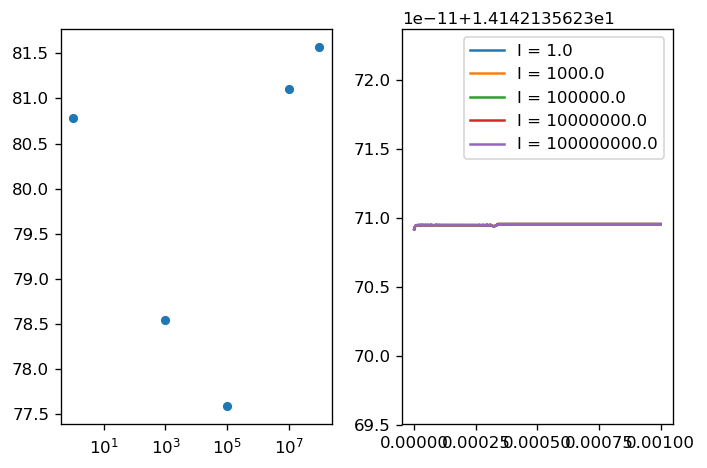

In [118]:
# scalability 
fig = plt.figure(dpi = 120)

ax1 = fig.add_subplot(1,2,1)

ax1.plot(M_vec, sim_time, ls = "None", marker = ".", markersize=  9)

ax1.set_xscale("log")

ax2 = fig.add_subplot(1,2,2)

for iterOut in range(0,solint.shape[0]):
    label = r"I = " + str(M_vec[iterOut])
    ax2.plot(time * T0, solint[iterOut,:], label = label)

#ax2.set_yscale("symlog", linthreshy = 1e-16)

ax2.legend()
fig.tight_layout()

plt.show()



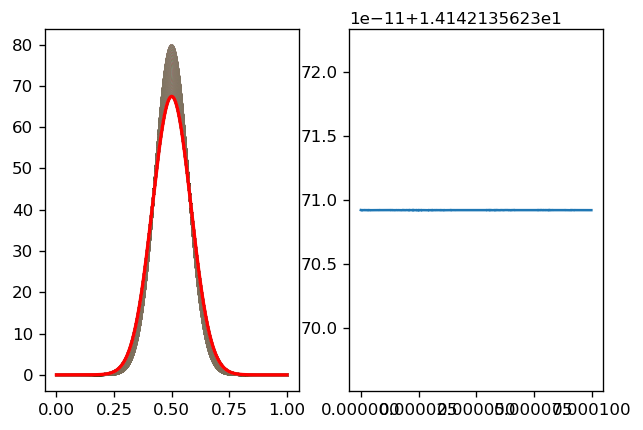

In [18]:
plot_index = 800
fig = plt.figure(dpi = 120)

ax1 = fig.add_subplot(1,2,1)

ax1.plot(centers, sol)

ax1.plot(centers, sol[:,-1], lw = 2, color = "red")

ax2 = fig.add_subplot(1,2,2)

ax2.plot(time, solint[-1,:])

#ax2.set_yscale("log")

plt.show()

Now approximate Jacobian, compute it numerically

secant method, but using tridiagonality

In [ ]:
def Jacobian_2( I, sol_new, p)

    A = np.zeros([I,I], dtype = np.float64)

    # inner points
    for i in range(1,I-1):
        
        A[i,i-1] = 
        A[i,i]
        A[i,i+1]